## Embeddings 1

### Take a word sample (e.g. a news article) and project the word embeddings for those words onto a 2D plot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16,16)

In [3]:
def loadWordVectors(tokens, filepath, dimensions=50):
    """Read pretrained GloVe vectors
    From bootcamp nlp assignment content
    """
    wordVectors = np.zeros((len(tokens), dimensions))
    i = 0
    with open(filepath, encoding='utf-8') as ifs:
        for line in ifs:
            line = line.strip()
            if line:
                row = line.split()
                token = row[0]
                if token in tokens:
                    data = [float(x) for x in row[1:]]
                    if len(data) != dimensions:
                        raise RuntimeError("wrong number of dimensions")
                    wordVectors[i, :] = np.asarray(data)
                    i += 1
#             wordVectors[tokens[token]] = np.asarray(data)
    return wordVectors

In [4]:
import string
punc_table = str.maketrans({key: None for key in '”“’.,-\")(}{?!`~_\\/\''})
def strip_punctuation(s):
#     https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
#     return s.translate(str.maketrans({key: None for key in string.punctuation}))
    return s.translate(punc_table)

In [5]:
from stop_words  import STOP_WORDS
STOP_WORDS = list(map(strip_punctuation, STOP_WORDS))
def not_stop_word(word):
    global STOP_WORDS
    return word not in STOP_WORDS

In [6]:
def process_text(text):
    return strip_punctuation(text).lower()

In [7]:
def replace_punctuation(s, char=' '):
    return s.translate(str.maketrans({key: char for key in ['.', ',', '\"']}))

In [8]:
def word_predicate(s):
    return not_stop_word(s) and \
           (not s.isnumeric()) and \
           len(s) > 1

In [9]:
def tokenize(text: str) -> list:
    words = filter(word_predicate, 
                   map(process_text, text.split()))
    return set(words)

In [10]:
# import requests
# from bs4 import BeautifulSoup

# page = requests.get('https://www.smithsonianmag.com/smart-news/fierce-t-rex-was-walker-not-sprinter-180964094/')
# dino_soup = BeautifulSoup(page.content, "html.parser")
# article = dino_soup.find('div', {'class':"article-body pagination-first"}).text.replace('\n',''
#                                                                                        ).replace('\xa0',' '
#                                                                                                 ).replace('-', ' ')
# with open('dino.txt', 'w') as f:
#     f.writelines(article)
    
# f = open('t-rex.txt')
# article = str(f.readlines()[0])
################################
f = open('bronto.txt')
article = ''.join(f.readlines())
article = replace_punctuation(article)
f.close()
article_tokens = tokenize(article)
model_file = 'data/glove.6B.50d.txt'

word_vectors = loadWordVectors(article_tokens, model_file)

In [11]:
def convert_colname(col):
    return '_{}'.format(col)

In [12]:
vec_df = pd.DataFrame(word_vectors)
vec_df.columns = [convert_colname(col) for col in vec_df.columns]
vec_df = vec_df.assign(word = article_tokens)

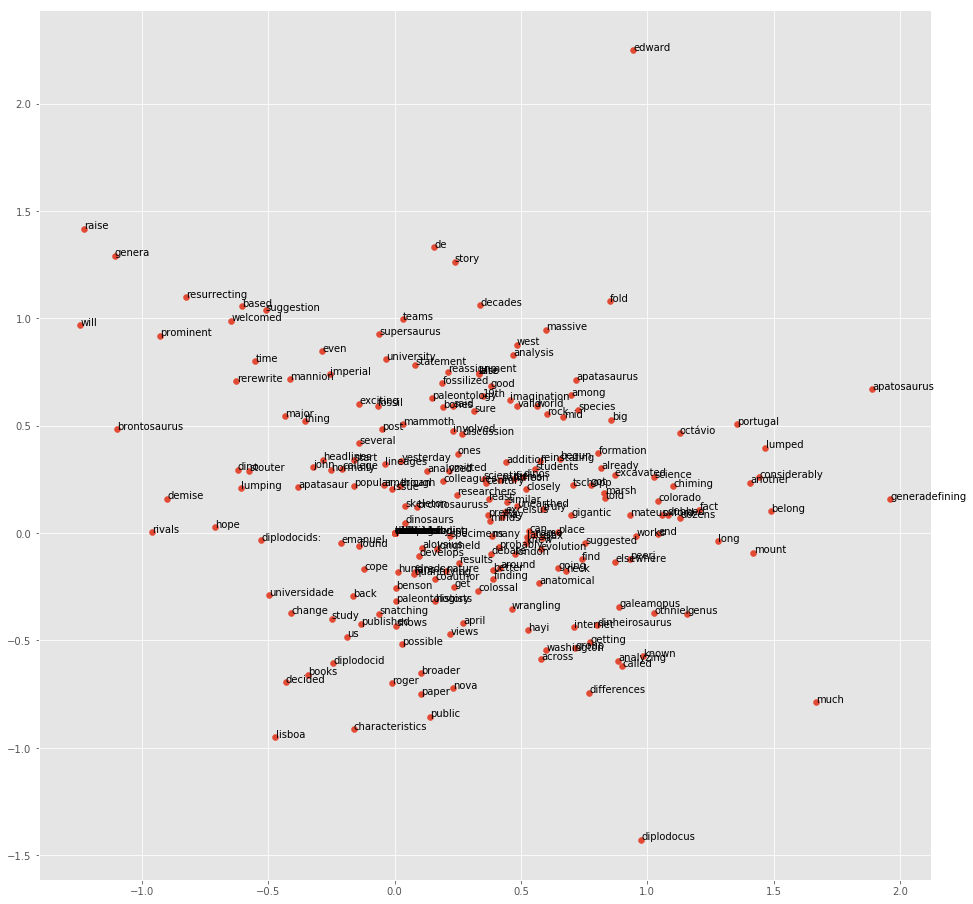

In [13]:
colx = convert_colname(0)
coly = convert_colname(1)
colz = convert_colname(2)
# fig, ax = plt.subplots(figsize=(16,16))

plt.scatter(vec_df[colx], vec_df[coly])
# plt.ylim((-.1,.1))
# plt.xlim((-.1,.1))
for i, word in enumerate(vec_df.word):
    posx = vec_df[colx][i] + .001
    posy = vec_df[coly][i]
    plt.annotate(word, xy=(posx, posy))

In [14]:
# vec_df[vec_df._0 == 0.].word

In [15]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

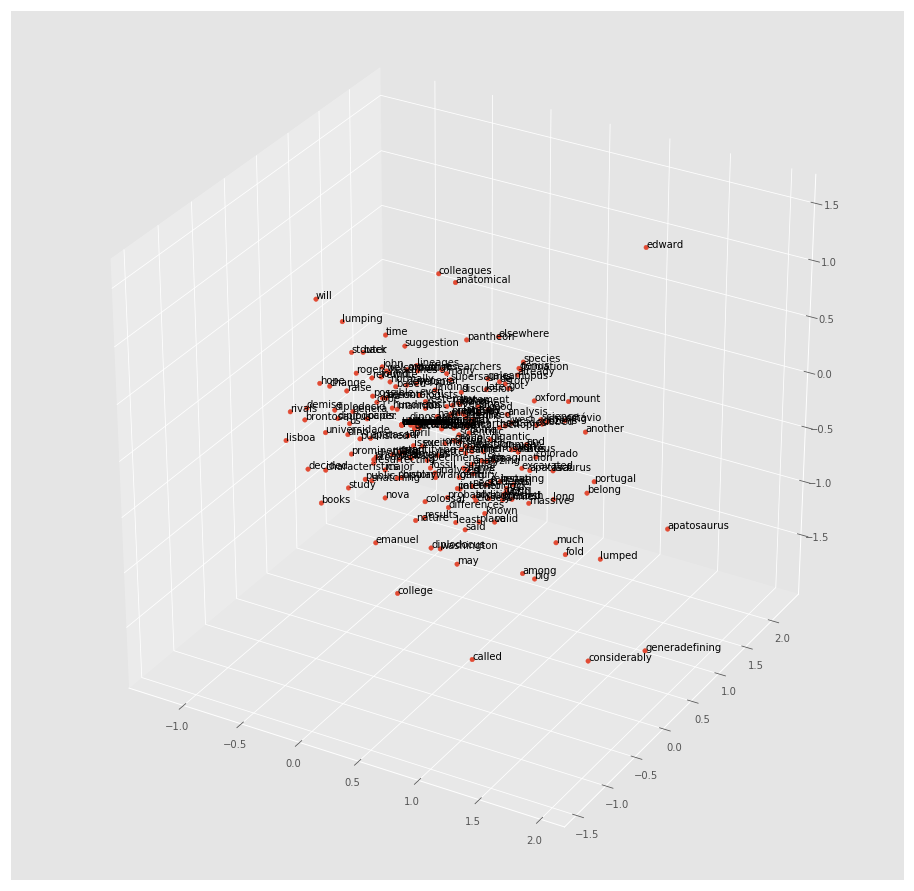

In [16]:
fig_3d = plt.figure(figsize=(16,16))
ax = fig_3d.add_subplot(111, projection='3d')
ax.scatter3D(vec_df[colx], vec_df[coly], vec_df[colz], alpha=1)

for i, word in enumerate(vec_df.word):
    posx = vec_df[colx][i]
    posy = vec_df[coly][i]
    posz = vec_df[colz][i]
    ax.text(posx, posy, posz, word)

In [17]:
from sklearn.decomposition import PCA

In [18]:
variances = []
n = 1
explained = 0
pca = None
while n < len(vec_df.columns)-1 and explained < 0.999:
    pca = PCA(n)
    pca.fit(vec_df.drop('word', axis=1))
    explained = sum(pca.explained_variance_ratio_)
    variances.append(explained)
    n += 1

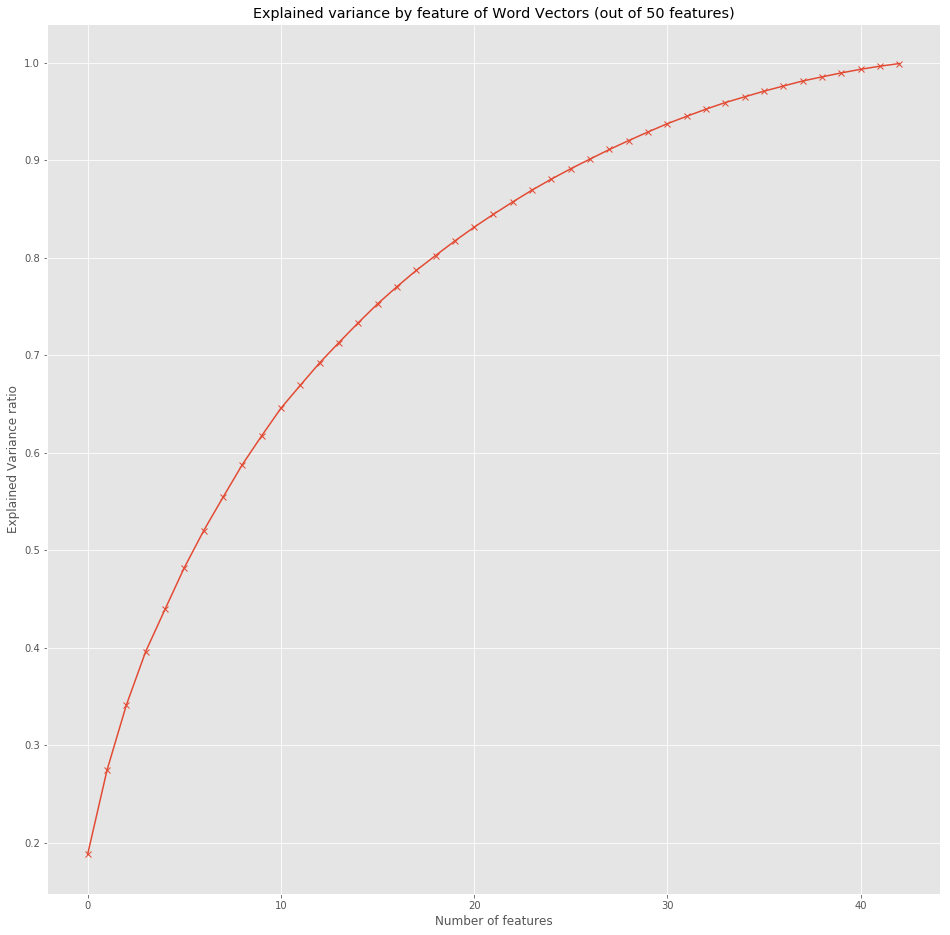

In [19]:
plt.plot(range(len(variances)), variances, marker='x')
plt.title('Explained variance by feature of Word Vectors (out of {} features)'.format(len(vec_df.columns)-1))
plt.xlabel('Number of features')
plt.ylabel('Explained Variance ratio')
None

### Clusterize the words (e.g. with k-means)

In [20]:
from sklearn.cluster import KMeans

In [21]:
def calc_plot_elbow(df):
    n = 10
    el = list()
    for i in range(1, n+1):
        km_ = KMeans(i)
        km_.fit(df.drop('word', axis=1))
        el.append(km_.inertia_)
        
    plt.plot(range(1, n+1), el, marker='x')
    plt.title("Elbow Plot of KMeans with 'n' clusters")
    plt.xlabel("Number of clusters")
    plt.ylabel("KMeans Inertia")

    return el

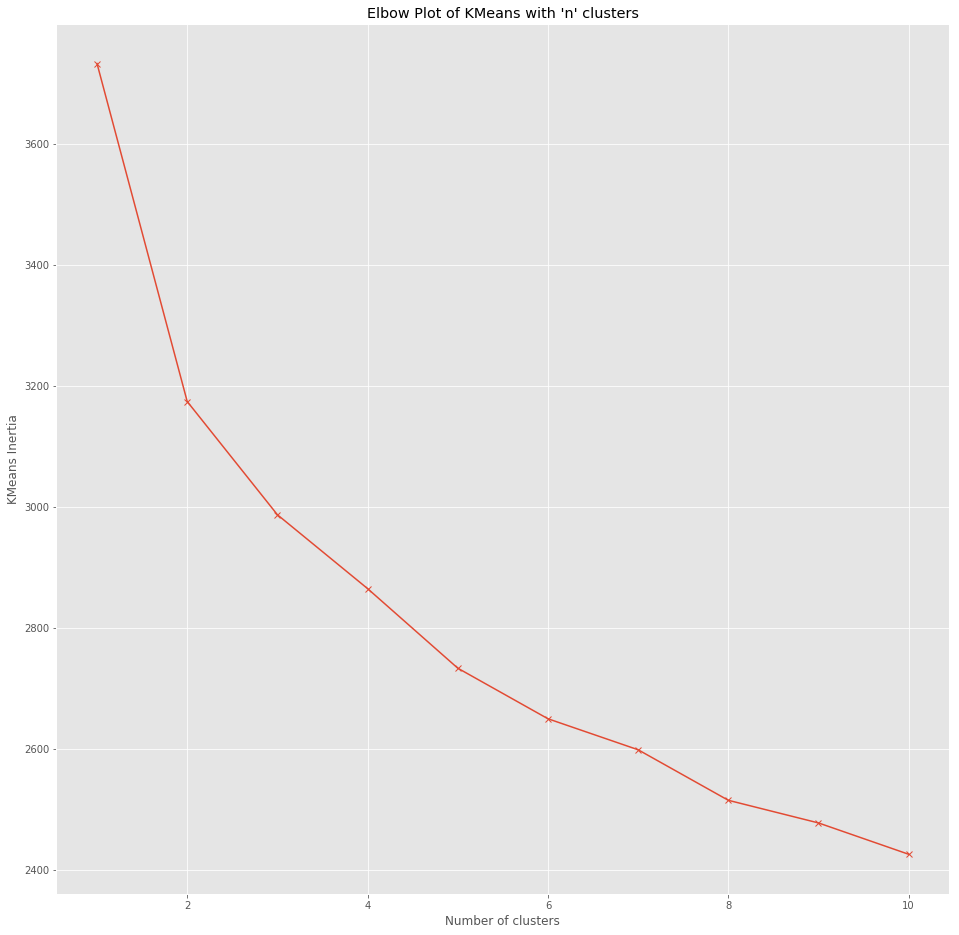

In [22]:
calc_plot_elbow(vec_df)
None

In [23]:
km = KMeans(2)

km.fit(vec_df.drop('word', axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [24]:
vec_df = vec_df.assign(km = km.labels_)

In [25]:
def plot_embedding_cluster(colx_, coly_, data, cluster_col):
    g = sns.scatterplot(colx_, coly_,
                        hue=cluster_col, 
                        data=data,
                        edgecolor='k',
                        legend='full',
                        palette='RdBu_r')

    for i, word in enumerate(data.word):
        posx = data[colx_][i] + .001
        posy = data[coly_][i]# + .01
        plt.annotate(word, xy=(posx, posy))

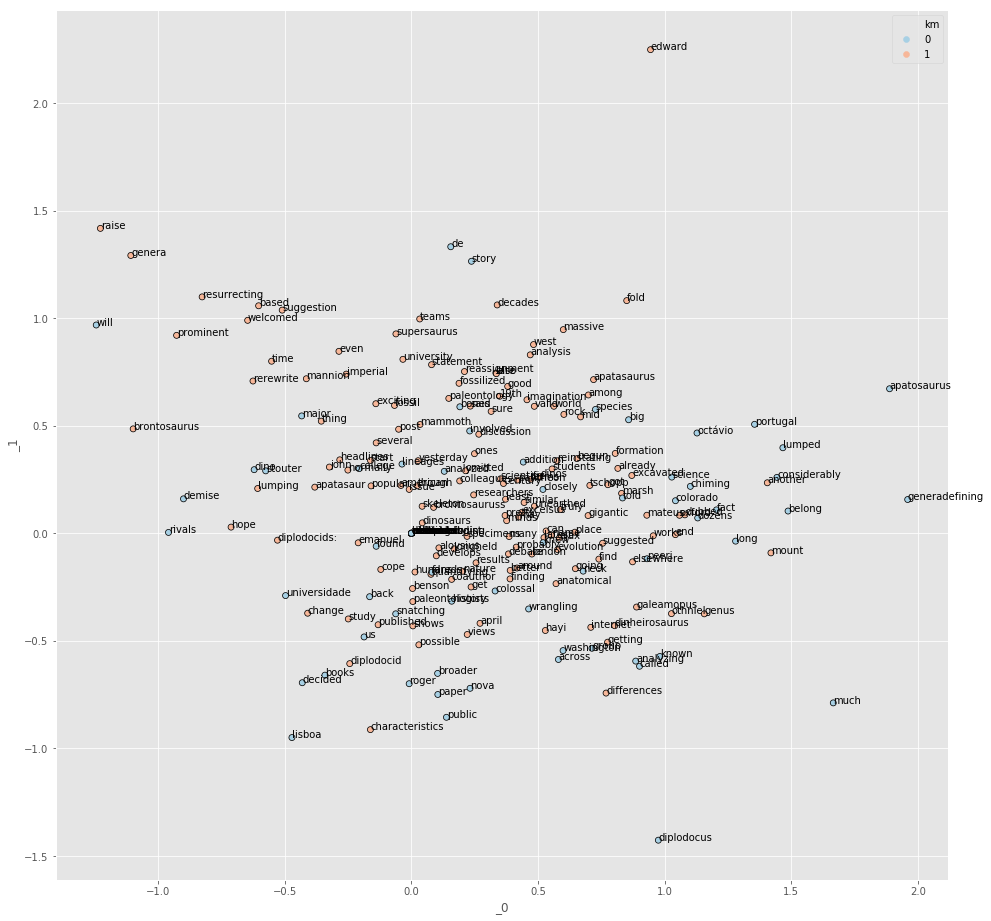

In [26]:
x, y = convert_colname(0), convert_colname(1)
plot_embedding_cluster(x, y, vec_df, 'km')

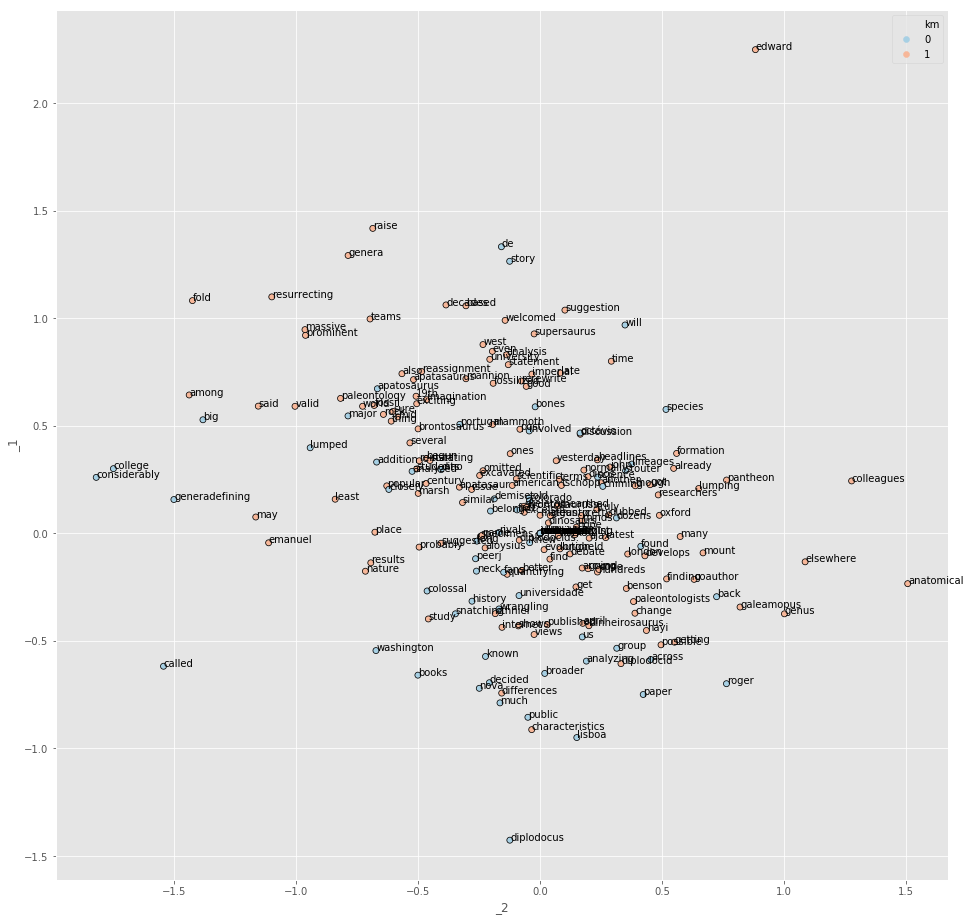

In [27]:
x, y = convert_colname(2), convert_colname(1)
plot_embedding_cluster(x, y, vec_df, 'km')

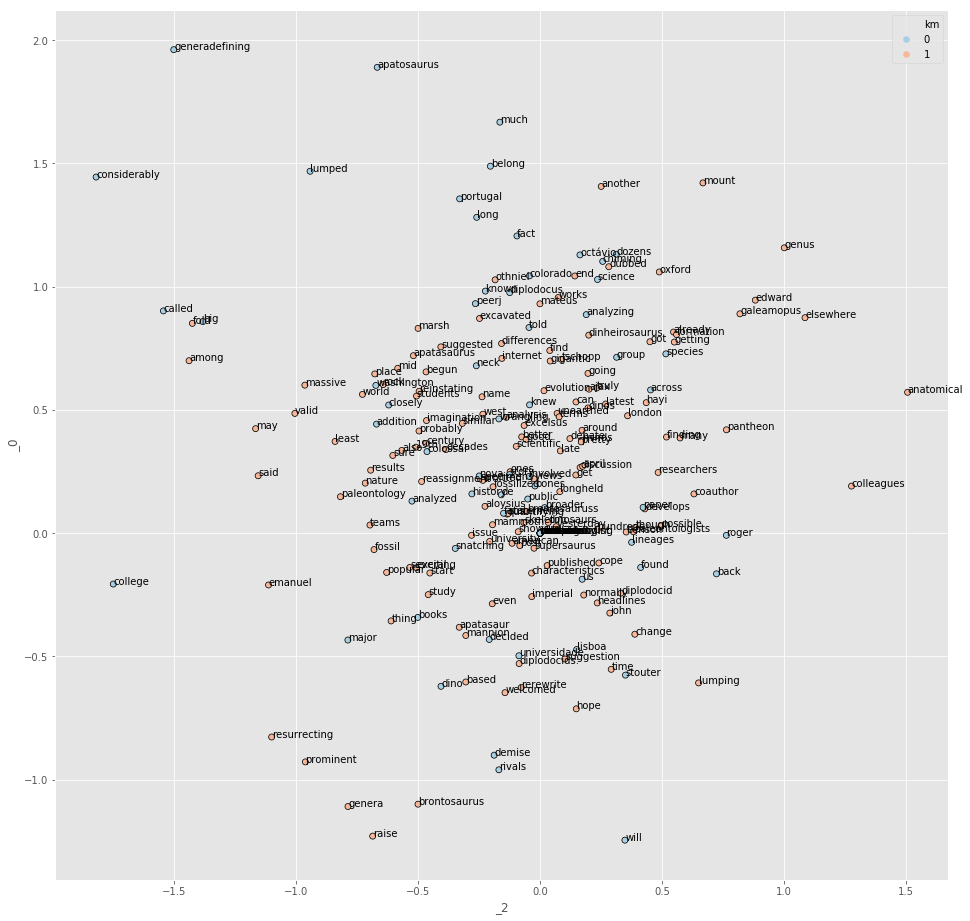

In [28]:
x, y = convert_colname(2), convert_colname(0)
plot_embedding_cluster(x, y, vec_df, 'km')

---

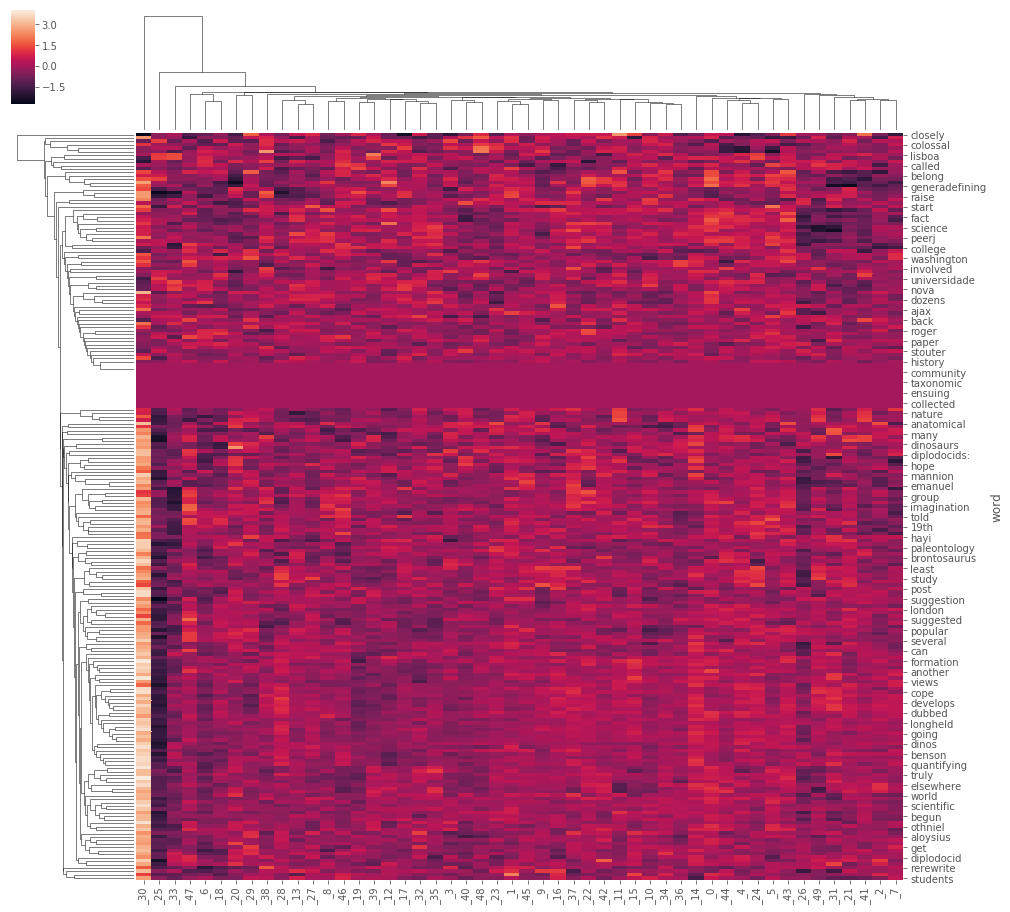

In [29]:
g = sns.clustermap(vec_df.drop('km', axis=1).set_index('word'), figsize=(16,16))
None

---

### Train your own GloVe embeddings on a large text dataset (e.g. Gutenberg )

In [30]:
# https://github.com/buomsoo-kim/Word-embedding-with-Python/blob/master/GloVe/source%20code/GloVe.ipynb

In [31]:
from nltk.corpus import gutenberg
from glove import Corpus, Glove
from multiprocessing import Pool
from scipy import spatial

In [32]:
bible = gutenberg.sents('bible-kjv.txt')
blake = gutenberg.sents('blake-poems.txt')
caesar = gutenberg.sents('shakespeare-caesar.txt')

In [33]:
# Cleaning
sentence_cleaner = lambda source: [list(filter(word_predicate, map(process_text, sent))) for sent in source]

In [34]:
bible_sentences = sentence_cleaner(bible)

In [35]:
blake_sentences = sentence_cleaner(blake)

In [36]:
corpus_bible = Corpus()
corpus_bible.fit(bible_sentences, window = 3)

In [37]:
corpus_blake = Corpus()
corpus_blake.fit(blake_sentences, window = 3)

In [38]:
no_components = 100
glove_bible = Glove(no_components = no_components, learning_rate = 0.05)

In [39]:
glove_bible.name = "Bible glove"

In [40]:
glove_blake = Glove(no_components = no_components, learning_rate = 0.05)

In [41]:
glove_blake.name = "Blake glove"

In [42]:
glove_bible.fit(matrix = corpus_bible.matrix, epochs = 10, no_threads = Pool()._processes, verbose = True)

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [43]:
glove_blake.fit(matrix = corpus_blake.matrix, epochs = 10, no_threads = Pool()._processes, verbose = True)

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [44]:
glove_bible.add_dictionary(corpus_bible.dictionary)
glove_blake.add_dictionary(corpus_blake.dictionary)

In [45]:
# glove.save('data/glove_model_bible')
# glove.save('data/glove_model_blake')
# glove.load('data/glove_model_bible')
# glove.load('data/glove_model_blake')

In [46]:
def vector_converter(word, glove_, no_components):
    output_vec = np.zeros(no_components)
    if word in glove_.dictionary:
        idx = glove_.dictionary[word]
        output_vec = glove_.word_vectors[idx]
        
    return output_vec

In [47]:
def generate_word_vectors(words, glove_, no_components):
    output_vec = np.zeros((len(words), no_components))
    for i, word in enumerate(words):
        if word in glove_.dictionary:
            idx = glove_.dictionary[word]
            output_vec[i, :] = glove_.word_vectors[idx]
        
    return output_vec

In [48]:
def cosine_similarity(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

In [49]:
def word_similarity(word1, word2, glove_, no_components, verbose=False):
    if word1 in glove_.dictionary and word2 in glove_.dictionary:
        vec1 = vector_converter(word1, glove_, no_components)
        vec2 = vector_converter(word2, glove_, no_components)
        output = cosine_similarity(vec1, vec2)
        if verbose:
            print("Using {}, the cosine similarity of {} and {} is {:.4f}".format(glove_.name, 
                                                                                  word1, 
                                                                                  word2, 
                                                                                  output))
        return output
    else:
        print("One or both of the words are missing in the model")
        return None
#         raise Exception("One of the words are missing in the model")
        
    

In [50]:
word_similarity('sea', 'desert', glove_bible, no_components, True)
word_similarity('sea', 'desert', glove_blake, no_components, True)
None

Using Bible glove, the cosine similarity of sea and desert is -0.7186
Using Blake glove, the cosine similarity of sea and desert is -0.0027


In [51]:
word_similarity('boy', 'son', glove_bible, no_components, True)
word_similarity('boy', 'son', glove_blake, no_components, True)
None

Using Bible glove, the cosine similarity of boy and son is -0.2063
Using Blake glove, the cosine similarity of boy and son is -0.0805


In [87]:
word_similarity('man', 'woman', glove_bible, no_components, True)
word_similarity('man', 'woman', glove_blake, no_components, True)
None

Using Bible glove, the cosine similarity of man and woman is 0.8467
Using Blake glove, the cosine similarity of man and woman is -0.0110


In [86]:
word_similarity('tree', 'angel', glove_bible, no_components, True)
word_similarity('tree', 'angel', glove_blake, no_components, True)
None

Using Bible glove, the cosine similarity of tree and angel is -0.7800
Using Blake glove, the cosine similarity of tree and angel is 0.2129


In [78]:
glove_bible.most_similar('god', 10)

[('power', 0.9765105327983795),
 ('doth', 0.9713636323448396),
 ('blessed', 0.9650128387466036),
 ('giveth', 0.9643019864982322),
 ('salvation', 0.9639711856038583),
 ('spirit', 0.9599271642476492),
 ('wisdom', 0.9586233163763038),
 ('glory', 0.9584723476626225),
 ('forbid', 0.9557071388056104)]

In [79]:
glove_blake.most_similar('god', 10)

[('lie', 0.3377308258172755),
 ('light', 0.3035230530113353),
 ('lamb', 0.2977073250602257),
 ('disguise', 0.28586915280940794),
 ('softest', 0.27105378094486593),
 ('spoil', 0.26251725807539944),
 ('har', 0.25798026624408676),
 ('mistress', 0.2579653493624417),
 ('worms', 0.2443109927893923)]

---

In [54]:
vec_df_bible = pd.DataFrame(generate_word_vectors(article_tokens, 
                                                  glove_bible, 
                                                  no_components))
vec_df_bible.columns = [convert_colname(col) for col in vec_df_bible.columns]
vec_df_bible = vec_df_bible.assign(word = article_tokens)

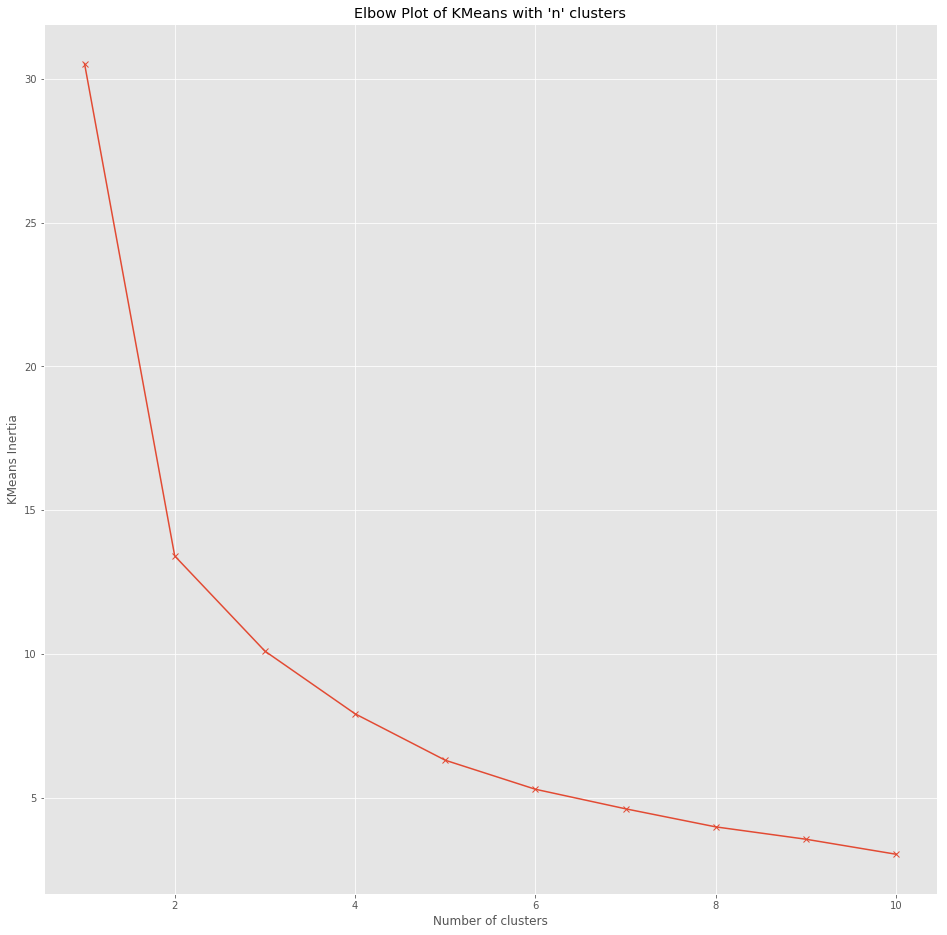

In [55]:
calc_plot_elbow(vec_df_bible)
None

In [56]:
km_bible = KMeans(2)

km_bible.fit(vec_df_bible.drop('word', axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [57]:
vec_df_bible = vec_df_bible.assign(km = km_bible.labels_)

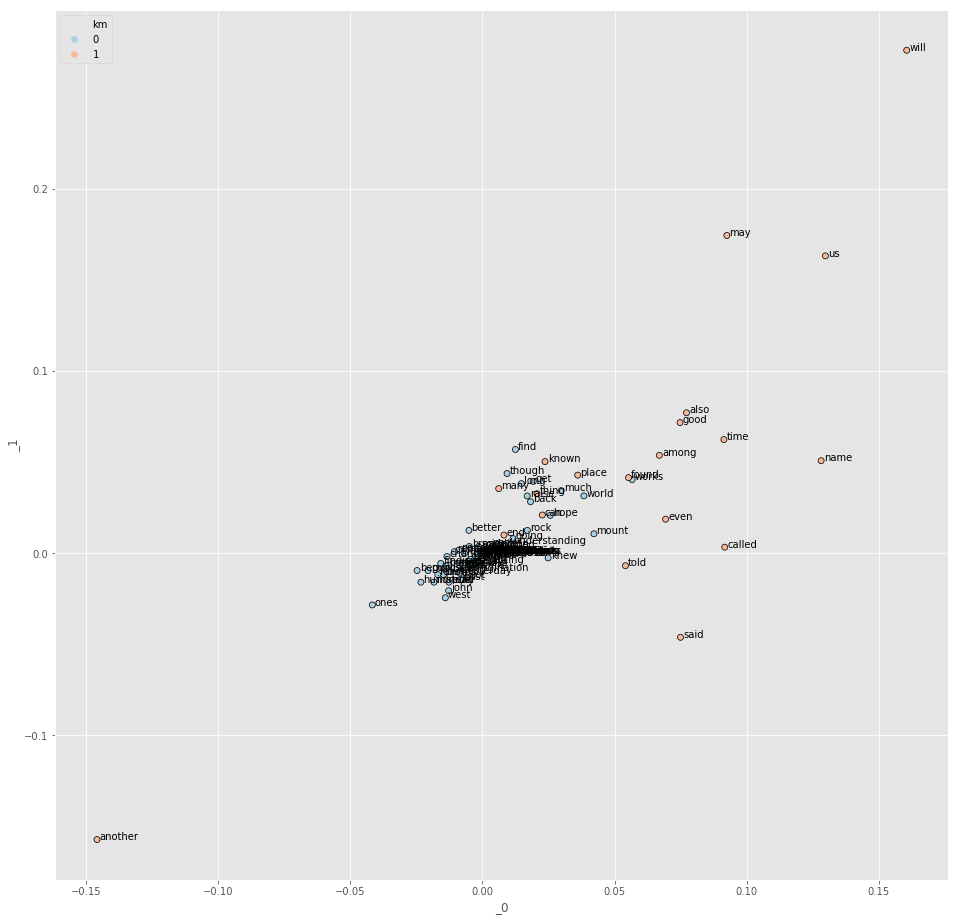

In [58]:
x, y = convert_colname(0), convert_colname(1)
plot_embedding_cluster(x, y, vec_df_bible, 'km')

(-0.01, 0.01)

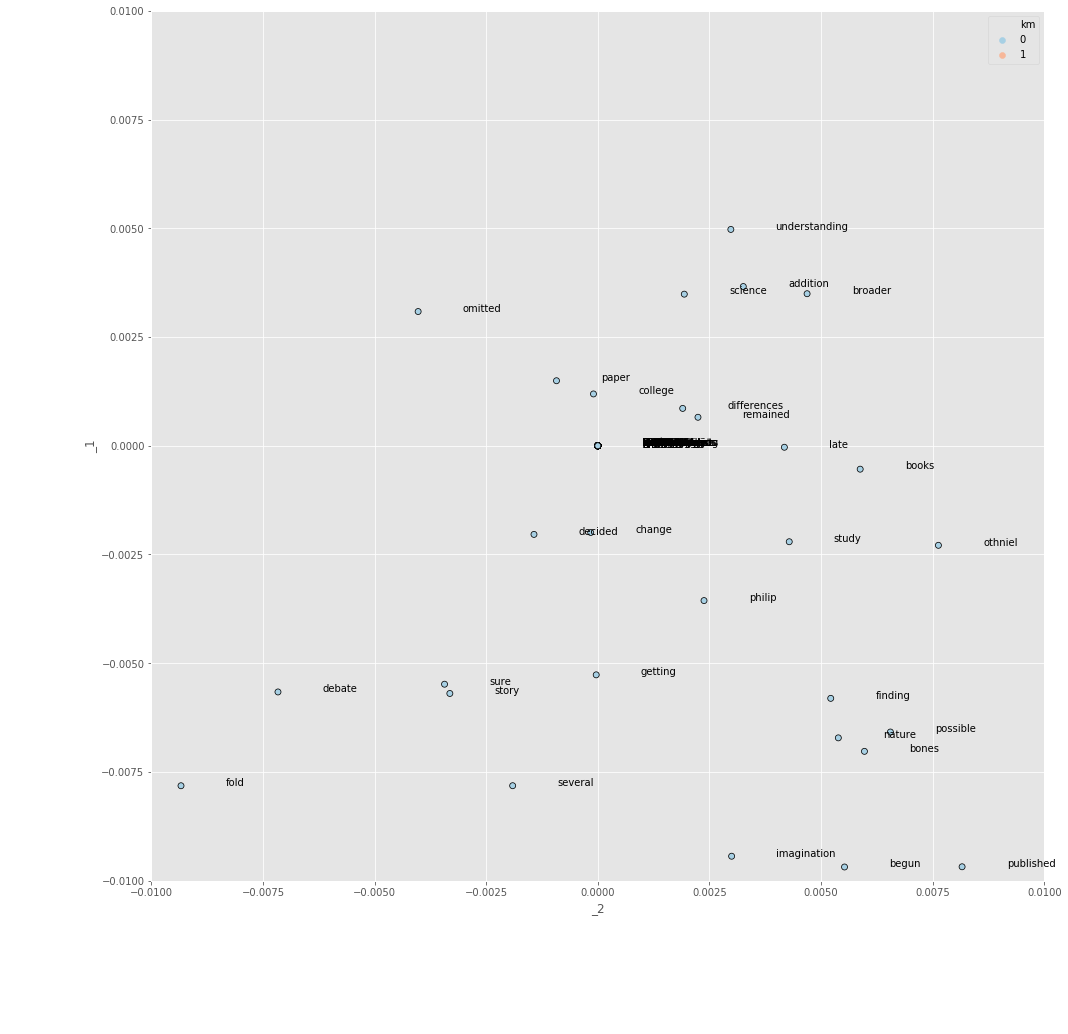

In [59]:
x, y = convert_colname(2), convert_colname(1)
plot_embedding_cluster(x, y, vec_df_bible, 'km')

window = 0.01
plt.ylim((-window, window))
plt.xlim((-window,window))

(-0.01, 0.01)

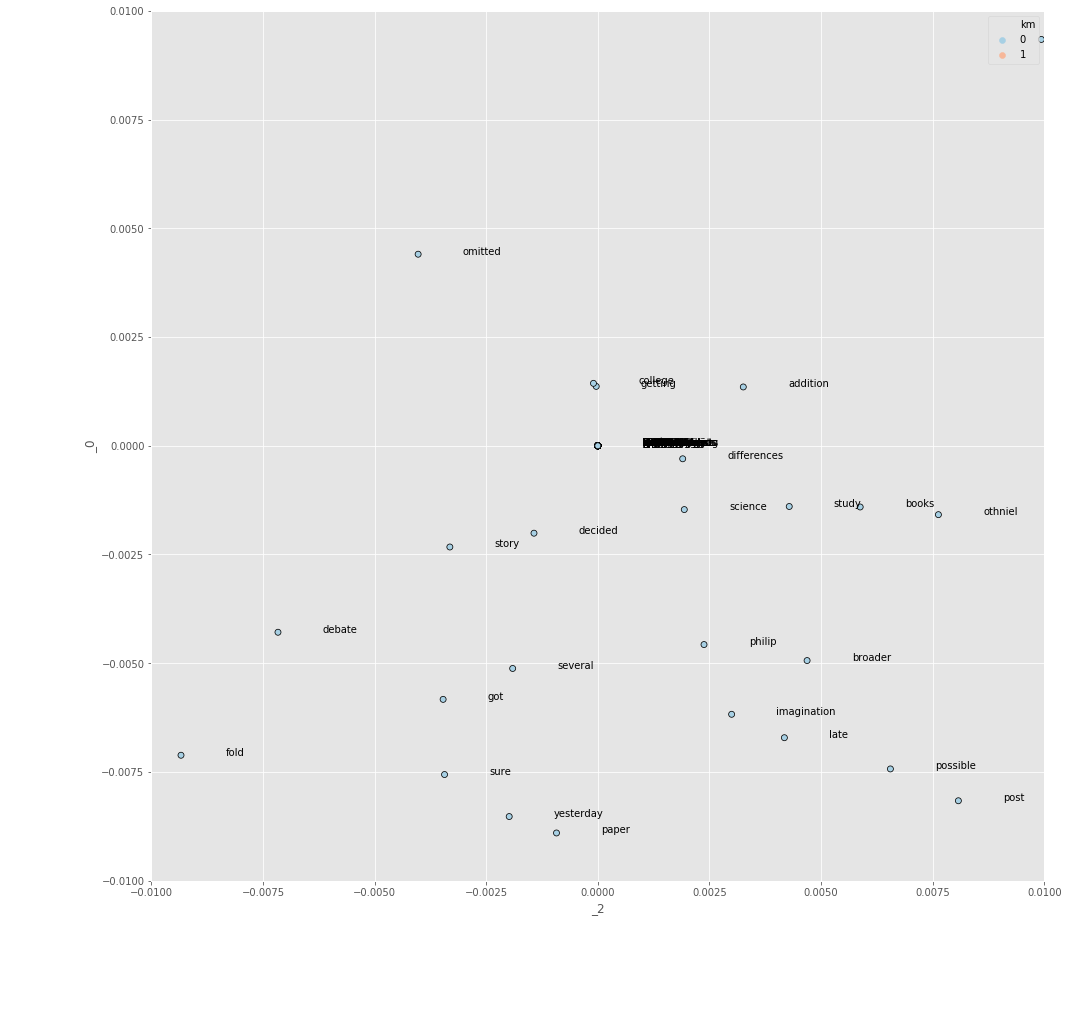

In [60]:
x, y = convert_colname(2), convert_colname(0)
plot_embedding_cluster(x, y, vec_df_bible, 'km')

window = 0.01
plt.ylim((-window, window))
plt.xlim((-window,window))

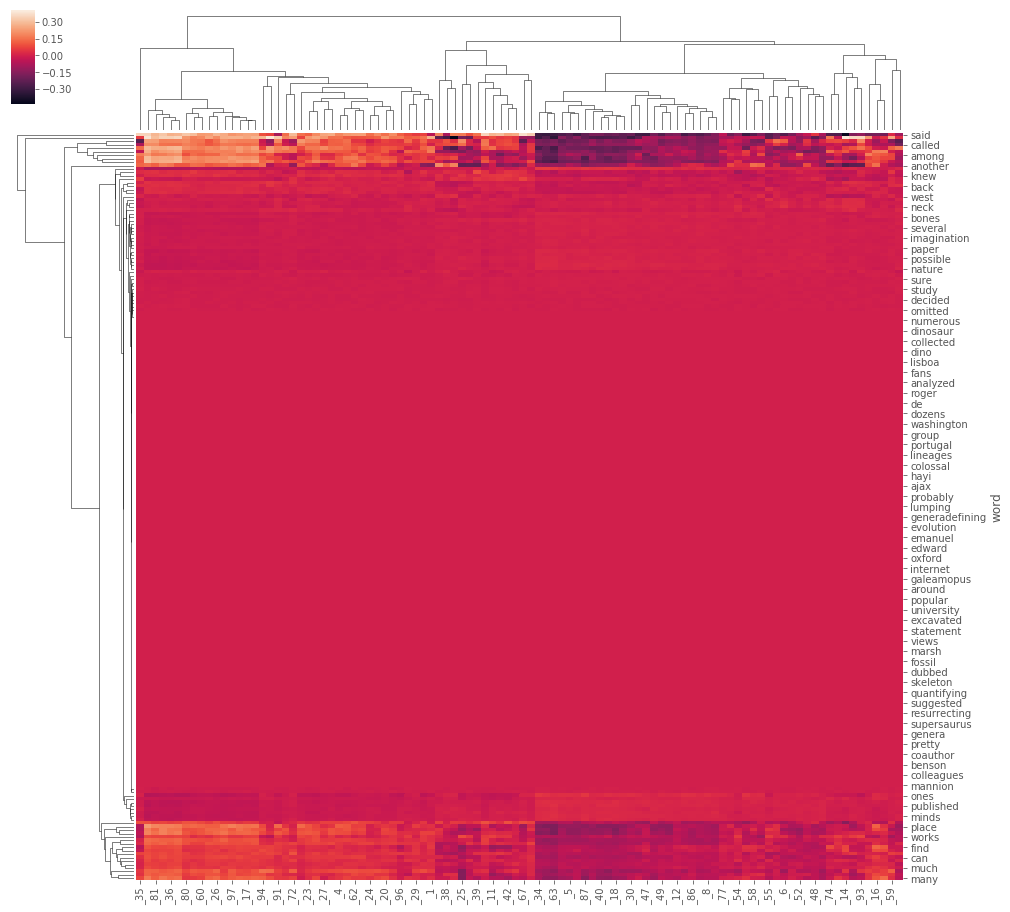

In [61]:
g = sns.clustermap(vec_df_bible.drop('km', axis=1).set_index('word'), figsize=(16,16))
None

---

In [62]:
vec_df_blake = pd.DataFrame(generate_word_vectors(article_tokens, 
                                                  glove_blake, 
                                                  no_components))
vec_df_blake.columns = [convert_colname(col) for col in vec_df_blake.columns]
vec_df_blake = vec_df_blake.assign(word = article_tokens)

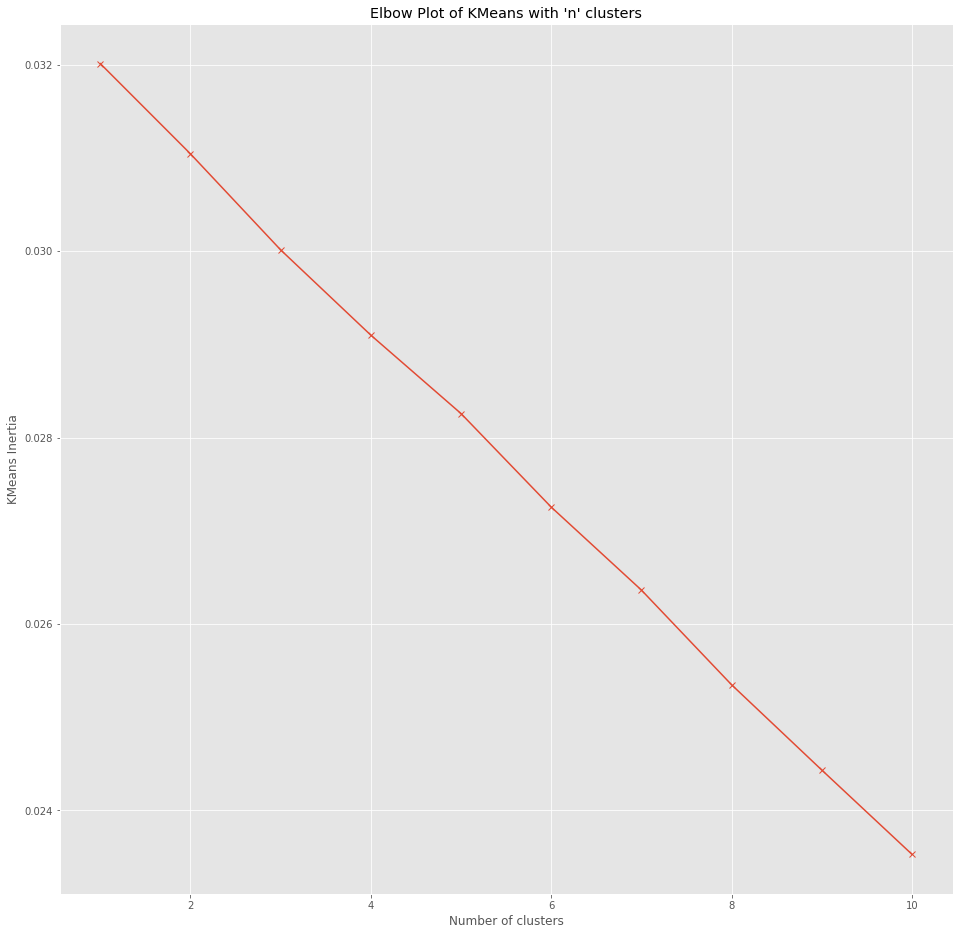

In [63]:
calc_plot_elbow(vec_df_blake)
None

In [64]:
km_blake = KMeans(2)

km_blake.fit(vec_df_blake.drop('word', axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [65]:
vec_df_blake = vec_df_blake.assign(km = km_blake.labels_)

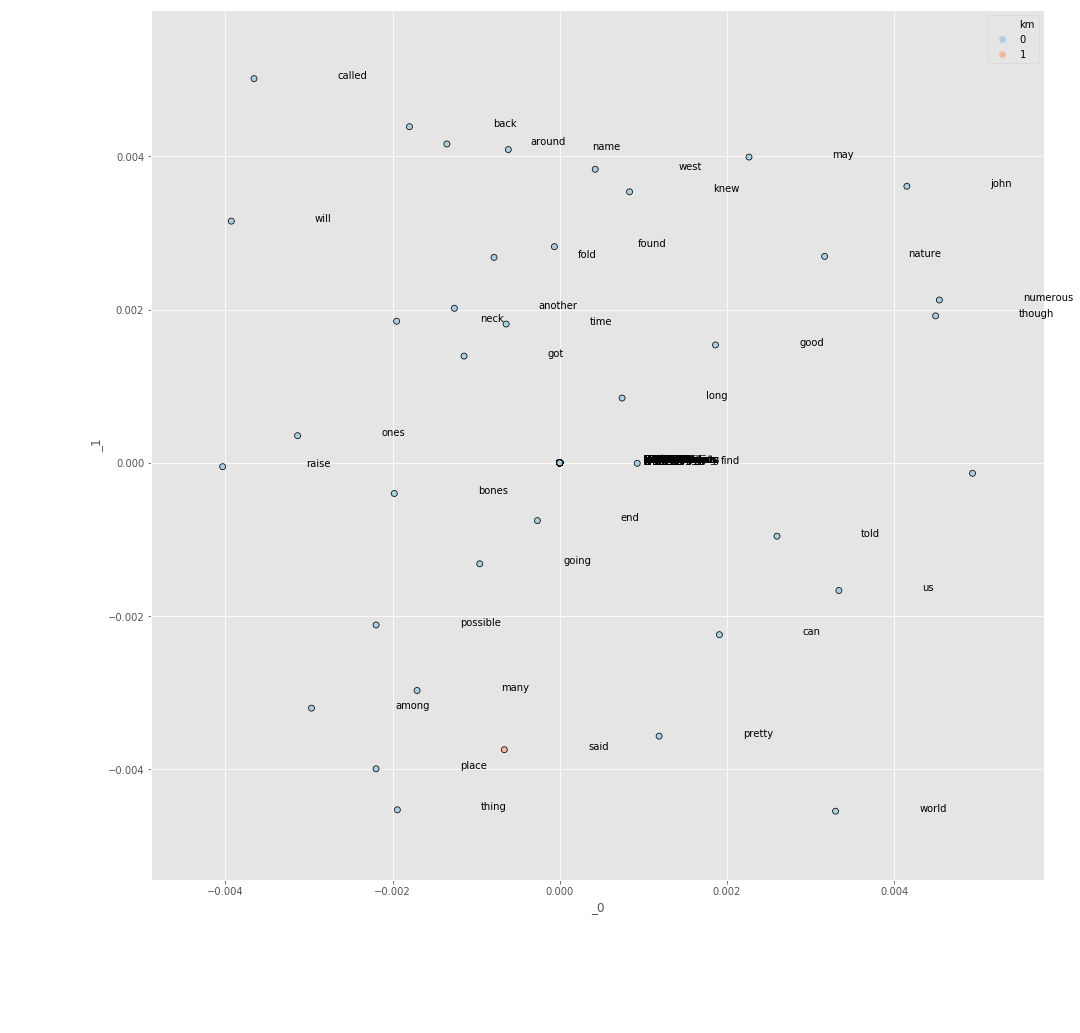

In [66]:
x, y = convert_colname(0), convert_colname(1)
plot_embedding_cluster(x, y, vec_df_blake, 'km')

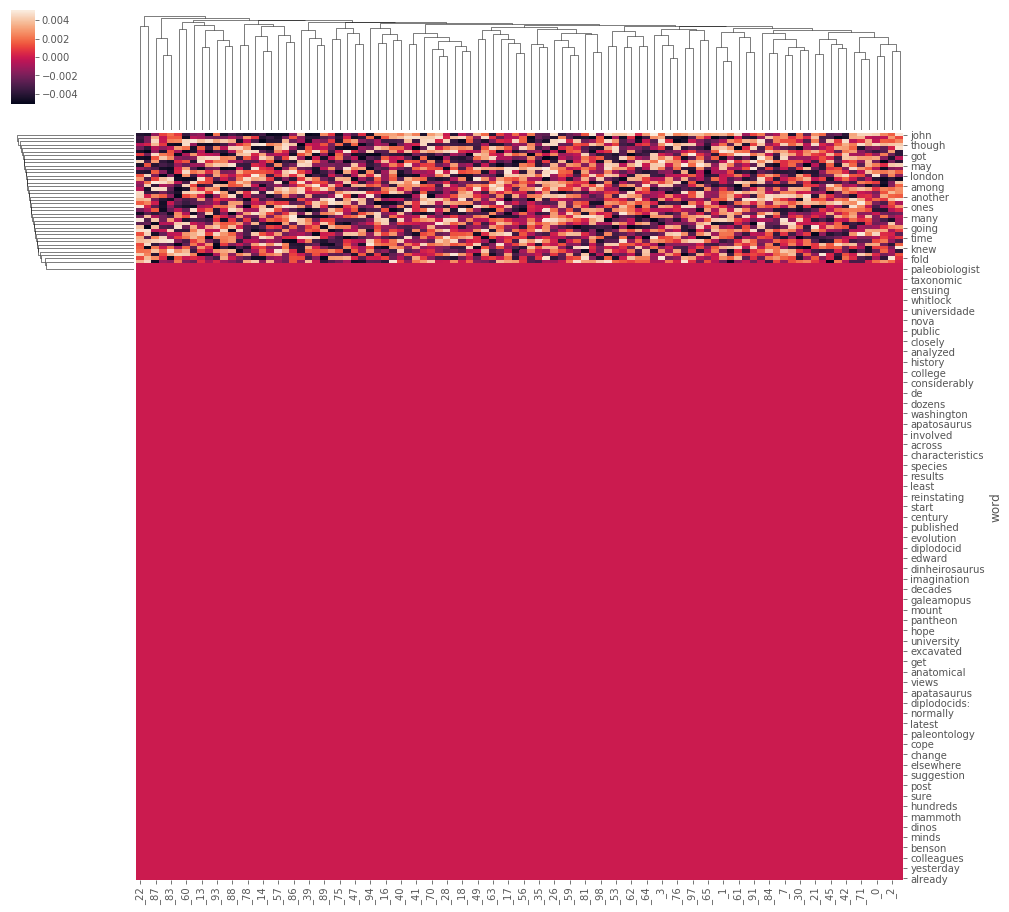

In [67]:
g = sns.clustermap(vec_df_blake.drop('km', axis=1).set_index('word'), 
                   figsize=(16,16))
None

### Compare performance of your embedding with an equivalent pretrained GloVe model (e.g. Wikipedia) choosing a task for the benchmark